# 15. 포식과 재포획

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

<br>

## 15.01. 그리즐리 곰 문제

> [1996년과 1997년 과학자들은 캐나다의 그리즐리 곰의 개체 수 추정을 위해 덫을 놓았다](https://www.researchgate.net/publication/229195465_Estimating_Population_Size_of_Grizzly_Bears_Using_Hair_Capture_DNA_Profiling_and_Mark-Recapture_Analysis).
> '덫'은 곰을 유인해서 털 표본을 채취하기 위한 미끼와 철조망 몇 줄로 만들어져 있으며, 과학자들은 털 표본을 사용해서 DNA분석을 해서 각각의 곰을 식별한다.
> 첫 실험에서는 과학자가 76개 지역에 덫을 설치했다. 10일 후 돌아온 과학자는 1,043개의 털 표본을 채취했고 이를 통해 23마리의 서로 다른 곰을 식별할 수 있었다. 
> 두 번째의 10일 실험에서는 19마리의 곰으로부터 1,191개의 털 표본을 얻었고, 이 중 4마리는 첫 번째 실험에서 파악된 곰인 것으로 확인

<br>

- **이 데이터로 곰의 개체수를 추정하려면, 각 실험간 각각의 곰이 관측될 확률을 모델링해야 함**

    **모집단의 모든 곰이 동일한 (알려지지 않은) 확률로 각 실험에 포착된다고 간단히 가정**
    - 실제 곰의 모집단 개체수가 100이라고 할 때,
        
        <br>
        
        * **$N$: 실제 개체수, 100.**

        * **$K$: 첫 실험에서 확인된 곰의 수, 23.**

        * **$n$: 두 번째 실험에서 관측된 곰의 수, 19**

        * **$k$: 두 번째 실험에서 관측된 곰 중 첫 실험에서 이미 확인된 곰의 수, 4.**
        
        <br>

    - **주어진 $N$, $K$, $n$을 사용해서 이전에 확인된 곰의 수인 $k$에 대한 확률은 [초기하분포](https://en.wikipedia.org/wiki/Hypergeometric_distribution)를 사용**

        $$\frac{\binom{K}{k} \binom{N-K}{n-k}} {\binom{N}{n}}$$

        * **[이항계수](https://en.wikipedia.org/wiki/Binomial_coefficient) $\binom{K}{k}$는 크기 $K$의 모집단에서 크기 $k$의 부분집합의 수**

        * **분자는 이전에 파악된 $K$에서 $k$마리의 곰을 고르고, 아직 파악되지 않은 $N-K$에서 $n-k$만큼을 고를 때 가능한 부분집합의 수**
        
        * **분모 $\binom{N}{n}$는 $N$마리의 곰 개체에서 $n$만큼의 곰을 골랐을 때 가능한 부분집합의 수**

<br>

#### `scipy.stats.hypergeom(N, K, n)` : 초기하분포 객체 생성
* **$N$, $K$, $n$이 주어졌을 때의 $k$의 분포가 결과로 표현**

In [7]:
import numpy as np
from scipy.stats import hypergeom
import matplotlib.pyplot as plt
from utils import decorate

In [5]:
N = 100
K = 23
n = 19

ks = np.arange(12)
ps = hypergeom(N, K, n).pmf(ks)

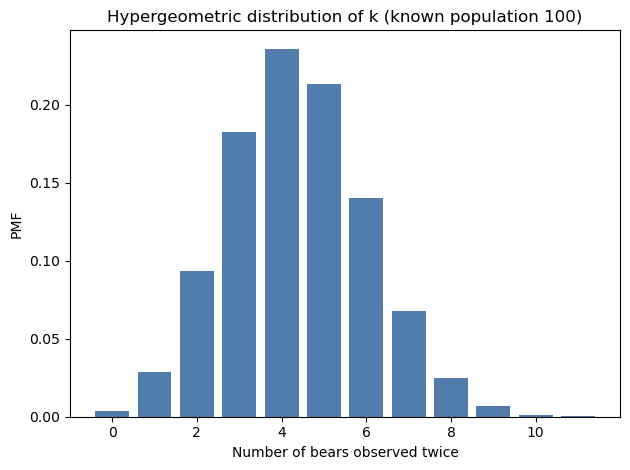

In [8]:


plt.bar(ks, ps)

decorate(xlabel='Number of bears observed twice', ylabel='PMF', title='Hypergeometric distribution of k (known population 100)')

#### 가장 가능성이 큰 $k$의 값은 4로, 이 실험에서 실제로 관측된 값과 동일
- **$N=100$은 모집단의 추정값으로 합리적이라고 판단 가능**

<br>

## 15.02. 갱신

### $K$, $n$, $k$가 주어졌을 때의 $N$을 추정하는 과정

<br>

#### 이 지역의 곰의 개체 수는 50과 500 사이의 균등분포를 따른다고 가정 (사전분포)

In [11]:
import numpy as np
from utils import make_uniform

In [14]:
qs = np.arange(50, 501)
prior_N = make_uniform(qs, name='N')
print(prior_N.shape)
prior_N.head()

(451,)


,probs
N,
50,0.002217
51,0.002217
52,0.002217


<br>

#### 초기하분포 객체를 통하여 가능도 계산

In [15]:
Ns = prior_N.qs
K = 23
n = 19
k = 4

likelihood = hypergeom(Ns, K, n).pmf(k)

<br>

####  사후분포 계산

In [16]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.07755224277106727

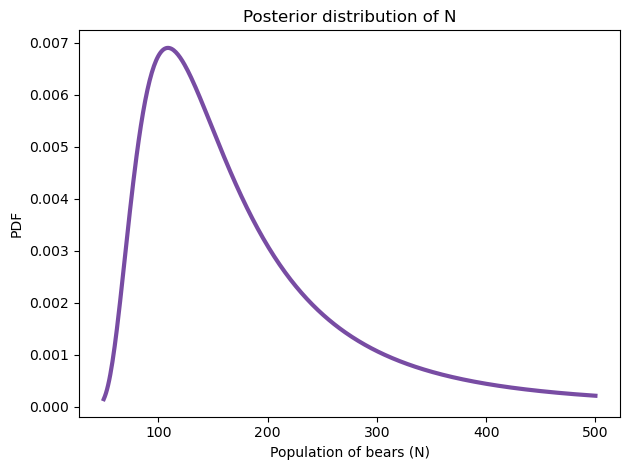

In [17]:
posterior_N.plot(color='C4')

decorate(xlabel='Population of bears (N)', ylabel='PDF', title='Posterior distribution of N')

<br>

#### 가장 가능성이 높은 값은 109

In [19]:
posterior_N.max_prob()

109

<br>

#### 분포가 오른쪽으로 더 몰려 있기에, 사후평균은 더 큰 값

In [20]:
posterior_N.mean()

173.79880627085637

<br>

#### 90% 신용구간

In [21]:
posterior_N.credible_interval(0.9)

array([ 77., 363.])

<br>

## 15.03. 두 개의 매개변수를 사용하는 모델

#### 곰의 수 $N$과 곰을 관측할 확률 $p$의 두 개의 매개변수를 사용하는 모델 생성
- 두 번의 실험에서의 확률은 동일하다고 가정 (덫의 형태나 설치 지역이 동일하므로 가능성 있는 가정)
- **확률은 서로 독립적이라고 가정. (즉, 2회차 실험에서 곰이 관측될 확률은 1회차에서 곰이 관측되었는지의 여부와 상관없음)**

In [22]:
K = 23
n = 19
k = 4

<br>

#### 2회차 이상의 실험을 하게 되는 경우에 대해 일반화를 진행

* `k10` : 1회차에서는 관측되었지만, 2회차에서는 관측되지 않은 곰의 수

* `k01` : 2회차에서는 관측되었지만, 1회차에서는 관측되지 않은 곰의 수

* `k11` : 양 회차에서 모두 관측된 곰의 수


In [23]:
k10 = 23 - 4
k01 = 19 - 4
k11 = 4

<br>

#### 실제 $N$과 $p$의 값을 알고 있다고 가정 $\rightarrow$ 이 값을 사용해서 데이터의 가능도를 계산
- 예) $N=100$이고 $p=0.2$라고 가정,$N$으로 아예 관측되지 않은 곰의 수인 `k00`을 예측

In [24]:
N = 100

observed = k01 + k10 + k11
k00 = N - observed
k00

62

- **$p=0.2$인 것을 알고 있으니, 각 그룹에 곰이 해당될 확률을 계산**
    - 1, 2회 실험에서 모두 관측될 확률은 $p\times p$,
    
        양쪽에서 모두 관측되지 않을 확률은 $q\times q$

In [25]:
x = [k00, k01, k10, k11]
x

[62, 15, 19, 4]

In [26]:
p = 0.2
q = 1-p
y = [q*q, q*p, p*q, p*p]
y

[0.6400000000000001,
 0.16000000000000003,
 0.16000000000000003,
 0.04000000000000001]

<br>

#### 데이터의 확률을 [다항분포](https://en.wikipedia.org/wiki/Multinomial_distribution)로 표현

$$\frac{N!}{\prod x_i!} \prod y_i^{x_i}$$

- **$N$이 모집단이이고**

    **$x$는 각 그룹의 수에 대한 수열**
    
    **$y$는 각 그룹의 확률에 대한 수열**

<br>

#### `scipy.stats.multinomial.pmf(x, N, y)` : 다항분포 객체 생성
- **`x` : 관측값에 대한 list**
- **`N` : 모집단의 크기**
- **`y` : 확률에 대한 list**

In [27]:
from scipy.stats import multinomial

In [31]:
x = [k00, k01, k10, k11]
print(x)

print(N)

y = [q*q, q*p, p*q, p*p]
print(y)

[62, 15, 19, 4]
100
[0.6400000000000001, 0.16000000000000003, 0.16000000000000003, 0.04000000000000001]


In [32]:
likelihood = multinomial.pmf(x, N, y)
likelihood

0.0016664011988507257

<br>

#### $N$과 $p$에 대한 사전확률분포를 선택한 후, 가능도로 값 갱신 필요

<br>

## 15.04. 사전분포

#### 모집단의 크기 $N$의 분포는 50 ~ 500사이의 균등분포를 따른다고 가정

In [35]:
qs = np.arange(50, 501)
prior_N = make_uniform(qs, name='N')

#### 각 곰을 관측할 확률의 분포는 $p$는 0% ~ 99%사이의 균등분포를 따른다고 가정

In [36]:
qs = np.linspace(0, 0.99, num=100)
prior_p = make_uniform(qs, name='p')

<br>

#### 결합분포 생성

In [38]:
from utils import make_joint

In [44]:
joint_prior = make_joint(prior_p, prior_N)
joint_prior.shape
joint_prior

p,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
N,,,,,,,,,,,,,,,,,,,,,
50,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
51,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
52,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
53,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
54,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
497,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
498,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022


In [40]:
from empiricaldist import Pmf

In [41]:
joint_pmf = Pmf(joint_prior.stack())
joint_pmf.head(3)

N   p   
50  0.00    0.000022
    0.01    0.000022
    0.02    0.000022
Name: , dtype: float64

In [50]:
joint_pmf.shape

(45100,)

<br>

## 15.05. 갱신


In [51]:
likelihood = joint_pmf.copy()

In [53]:
observed = k01 + k10 + k11
observed

38

#### 매개변수 쌍 별로 데이터에 대한 가능도를 계산

In [61]:
for N, p in joint_pmf.index:
    
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1-p
    y = [q*q, q*p, p*q, p*p]
    likelihood[N, p] = multinomial.pmf(x, N, y)

<br>

#### 사후분포 계산

In [62]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.9678796190279657e-05

In [63]:
joint_posterior = posterior_pmf.unstack()
joint_posterior

p,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
N,,,,,,,,,,,,,,,,,,,,,
50,0.0,6.936668e-60,1.693097e-47,2.323608e-40,2.251960e-35,1.442178e-31,1.652257e-28,5.760210e-26,8.390407e-24,6.264635e-22,...,1.487630e-35,5.249448e-38,8.966390e-41,6.113357e-44,1.254446e-47,4.999900e-52,1.858578e-57,1.628378e-64,1.533008e-74,8.146814e-92
51,0.0,2.667154e-59,6.379120e-47,8.576956e-40,8.141980e-35,5.106143e-31,5.727435e-28,1.954479e-25,2.786028e-23,2.035192e-21,...,5.836088e-37,1.668113e-39,2.251254e-42,1.175175e-45,1.771664e-49,4.903748e-54,1.166615e-59,5.749427e-67,2.405644e-77,3.196058e-95
52,0.0,9.709432e-59,2.275560e-46,2.997450e-39,2.787070e-34,1.711652e-30,1.879711e-27,6.278736e-25,8.758636e-23,6.259843e-21,...,2.167690e-38,5.018637e-41,5.351551e-44,2.138819e-47,2.368968e-51,4.553480e-56,6.933029e-62,1.921951e-69,3.574100e-80,1.187107e-98
53,0.0,3.362396e-58,7.721915e-46,9.965063e-39,9.075591e-34,5.458173e-30,5.868559e-27,1.918769e-24,2.619369e-22,1.831601e-20,...,7.659171e-40,1.436334e-42,1.210164e-45,3.703009e-49,3.013327e-53,4.022241e-58,3.919472e-64,6.111805e-72,5.051394e-83,4.194445e-102
54,0.0,1.112226e-57,2.502943e-45,3.164443e-38,2.822872e-33,1.662525e-29,1.750092e-26,5.600959e-24,7.482491e-22,5.119027e-20,...,2.584970e-41,3.926578e-44,2.613954e-47,6.123851e-51,3.661192e-55,3.393766e-60,2.116515e-66,1.856461e-74,6.819382e-86,1.415625e-105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,8.742606e-18,2.490220e-09,3.634514e-06,3.407196e-05,1.915893e-05,1.745900e-06,4.376479e-08,4.134486e-10,1.801831e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
497,0.0,9.278014e-18,2.589606e-09,3.702827e-06,3.400034e-05,1.872243e-05,1.670394e-06,4.098590e-08,3.789142e-10,1.615625e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
498,0.0,9.844574e-18,2.692510e-09,3.771798e-06,3.392323e-05,1.829283e-05,1.597887e-06,3.837707e-08,3.472066e-10,1.448421e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


<br>

#### 등고선 시각화
- **가장 가능성 높은 $N$값은 이전과 마찬가지로, 대략 100**
- **가장 가능성 높은 $p$의 값은 약 0.2**

- **등고선의 형태를 봤을 때, 매개변수들이 서로 음의 상관관계가 존재**

In [64]:
from utils import plot_contour

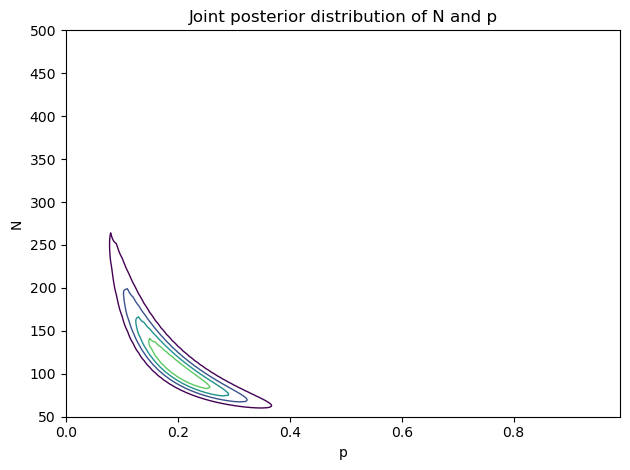

In [65]:
plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

<br>

#### 사후주변분포 계산

In [66]:
from utils import marginal

In [68]:
posterior2_p = marginal(joint_posterior, 0)
posterior2_N = marginal(joint_posterior, 1)

<br>

#### $p$에 대한 사후주변분포
- 가장 가능성이 높은 값은 0.2

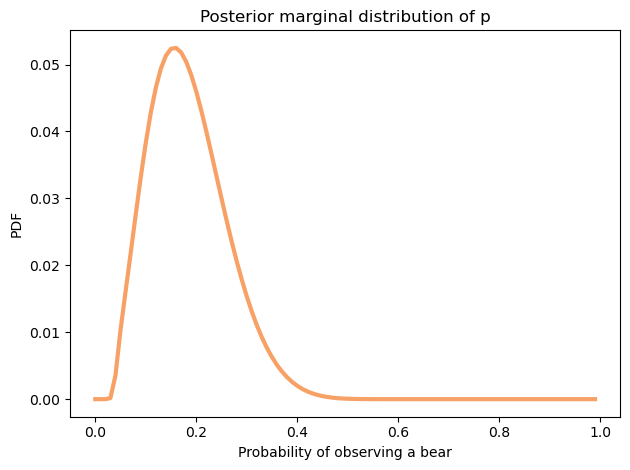

In [69]:
posterior2_p.plot(color='C1')

decorate(xlabel='Probability of observing a bear', ylabel='PDF', title='Posterior marginal distribution of p')

<br>

#### 단일 매개변수 (초기하분포)를 사용한 모델과, 두 개의 매개변수 (다항분포)를 사용한 모델 간의 비교
- **두 개의 매개변수 모델에서 평균은 좀 더 낮아지고, 90% 신용구간은 좀 더 좁아짐**
    - 두 개의 매개변수 모델은 단일 매개변수 모델에 비해더 좁은 사후 분포를 생성 (**추가적인 정보의 이점이 존재**)

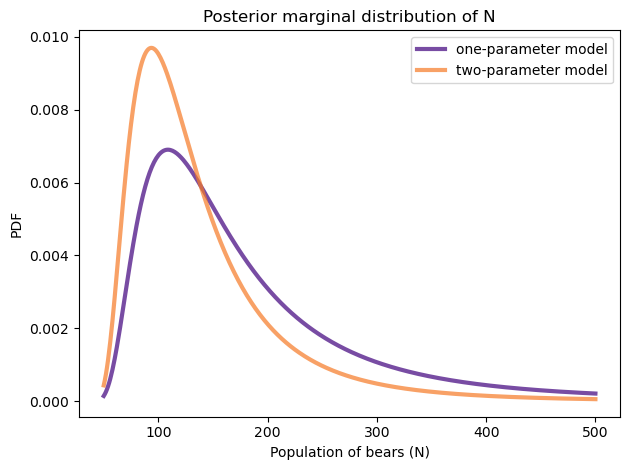

In [70]:
posterior_N.plot(label='one-parameter model', color='C4')
posterior2_N.plot(label='two-parameter model', color='C1')

decorate(xlabel='Population of bears (N)', ylabel='PDF', title='Posterior marginal distribution of N')

In [71]:
print(posterior_N.mean(), posterior_N.credible_interval(0.9))

173.79880627085637 [ 77. 363.]


In [72]:
print(posterior2_N.mean(), posterior2_N.credible_interval(0.9))

138.750521364726 [ 68. 277.]


<br>

### N에 대한 2개의 사후주변분포별 시뮬레이션

<br>

#### 1. 'N'이 138(복수 매개변수 모델의 사후 평균)일 때의 시나리오

In [83]:
N1 = 138

#### 첫 번째 시도에서 23마리의 곰을 관측, 두 번째 시도에서 19마리의 곰을 관측 
#### $\rightarrow$ 한번의 시도에서 관측할 수 있는 곰의 평균 수$=\frac{23+19}{2}=21$
**$\rightarrow$ $\hat{p} = 21/138=15.22\%$**

In [80]:
mean = (23 + 19) / 2
p = mean/N1
p

0.15217391304347827

#### $B(138,\;0.15217)$인 이항분포의 표준편차 = 4.2195

In [81]:
from scipy.stats import binom

In [82]:
binom(N1, p).std()

4.219519857292647

#### 2. 'N'이 173(단일 매개변수 모델의 사후 평균)일 때의 시나리오

In [85]:
N2 = 173
p = mean/N2
p

0.12138728323699421

#### $B(173,\;0.15217)$인 이항분포의 표준편차 = 4.2954

In [86]:
binom(N2, p).std()

4.2954472470306415

#### 관찰한 곰의 수가 두 실험에서 유사하다면, $N$에 대하여 높은 일관성을 기대할 수 있음
#### 두 실험 사이에 곰의 수가 상당히 다르다면, $N$에 대하여 높은 일관성을 기대할 수 없음

<br>

## 15.06. 링컨지수

다음은 독립적인 두 검수자의 결과를 비교함으로써, 프로그램의 오류 갯수를 추정하는 방법인 [링컨지수](http://www.johndcook.com/blog/2010/07/13/lincoln-index/)에 대한 설명

> 한 검수자가 프로그램에서 20개의 버그를 발견했다고 헀을 때, 실제로 프로그램에는 몇 개의 버그가 있는지 추정
>
> 프로그램에 최소한 20개의 버그가 있다는 것은 알고 있음
>

<br>

#### **첫 검수자가 20개의 버그를 발견했고, 두 번째 검수자가 15개의 버그를 발견했으며, 이 중 겹치는 것은 3개였을 때, 총 버그의 수는?**

In [89]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

<br>

#### 검수자가 버그를 발견할 확률이 동일하다고 가정하는 것은 적절하지 않음 $\rightarrow$ 매개변수를 따로 설정
- **`p0` : 첫 번째 검수자가 버그를 발견할 확률**
- **`p1` : 두 번째 검수자가 버그를 발견할 확률**

<br>

#### 모든 버그는 독립적이고 발견될 확률은 동일하다고 가정

In [90]:
p0, p1 = 0.2, 0.15

<br>

#### 버그에 대한 4개의 유형
1. 특정 버그가 두 검수자 모두에게 발견
2. 특정 버그가 첫 검수자에게는 발견, 두 번째 검수자에게는 발견 X
3. 특정 버그가 첫 검수자에게는 발견 X, 두 번째 검수자에게는 발견
4. 특정 버그가 두 검수자 모두에게 발견 X

In [91]:
def compute_probs(p0, p1):
    """4개의 각 유형에 대한 확률 계산"""
    q0 = 1-p0
    q1 = 1-p1
    return [q0*q1, q0*p1, p0*q1, p0*p1]

In [92]:
y = compute_probs(p0, p1)
y

[0.68, 0.12, 0.17, 0.03]

#### 두 검수자 모두가 특정 버그를 발견하지 못할 확률은 68%, 모두 발견할 확률은 3%

<br>

#### $N$에 대한 사후분포 계산
- **$N$의 사전분포는 32 ~ 350 사이의 균등분포로 가정** 

In [93]:
qs = np.arange(32, 350, step=5) 
prior_N = make_uniform(qs, name='N')
prior_N.head(3)

,probs
N,
32,0.015625
37,0.015625
42,0.015625


<br>

#### 가능도 계산

In [97]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

In [98]:
data = np.array([0, k01, k10, k11])

In [99]:
likelihood = prior_N.copy()
observed = data.sum()
x = data.copy()

In [100]:
for N in prior_N.qs:
    x[0] = N - observed
    likelihood[N] = multinomial.pmf(x, N, y)

<br>

#### 사후분포 계산

In [101]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.0003425201572557094

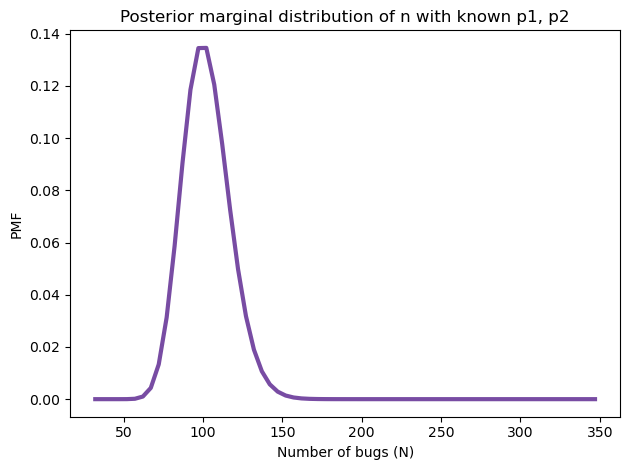

In [102]:
posterior_N.plot(color='C4')

decorate(xlabel='Number of bugs (N)', ylabel='PMF', title='Posterior marginal distribution of n with known p1, p2')

In [103]:
print(posterior_N.mean(), posterior_N.credible_interval(0.9))

102.1249999999998 [ 77. 127.]


#### `p0`과 `p1`이 각각 0.2와 0.15라고 알고 있다는 가정 하에서, 사후평균은 102
#### 90% 신용구간은 (77, 127)

<br>

### 하지만 이 결과는 버그를 발견할 확률을 알고 있다는 가정을 기반하기에 비현실적

<br>

## 15.07. 세 개의 매개변수를 사용하는 모델

<br>

#### `N`, `p0`, `p1` 3개의 매개변수를 사용하는 모델이 필요

<br>

#### **$N$의 사전분포는 32 ~ 350 사이의 균등분포로 가정** 

In [107]:
qs = np.arange(32, 350, step=5) 
prior_N = make_uniform(qs, name='N')

#### `p0`과 `p1`의 사전분포는 0% ~ 100%사이의 균등분포로 가정

In [108]:
qs = np.linspace(0, 1, num=51)
prior_p0 = make_uniform(qs, name='p0')
prior_p1 = make_uniform(qs, name='p1')

<br>

#### 3차원 사전결합분포 생성
- **1. `p0`과 `N`의 결합분포 생성**

In [109]:
joint2 = make_joint(prior_p0, prior_N)
joint2.shape
joint2

p0,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00
N,,,,,,,,,,,,,,,,,,,,,
32,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306
37,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306
42,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306
47,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306
52,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306
332,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306
337,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306


In [110]:
joint2_pmf = Pmf(joint2.stack())
joint2_pmf.head(3)

N   p0  
32  0.00    0.000306
    0.02    0.000306
    0.04    0.000306
Name: , dtype: float64

<br>

- **2. `p1`과 결합분포(`p0` & `N`)와  결합분포 생성**

In [111]:
joint3 = make_joint(prior_p1, joint2_pmf)
joint3.shape

(3264, 51)

In [112]:
joint3

p1            0.00      0.02      0.04      0.06      0.08      0.10  \
N   p0                                                                 
32  0.00  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.02  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.04  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.06  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.08  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
...            ...       ...       ...       ...       ...       ...   
347 0.92  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.94  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.96  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.98  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    1.00  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

p1            0.12      0.14      0.16      0.18  ...      0.82      0.84  \
N   p0                                            ...                       
32  0.00  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    0.02  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    0.04  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    0.06  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    0.08  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
...            ...       ...       ...       ...  ...       ...       ...   
347 0.92  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    0.94  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    0.96  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    0.98  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   
    1.00  0.000006  0.000006  0.000006  0.000006  ...  0.000006  0.000006   

p1            0.86      0.88      0.90      0.92      0.94      0.96  \
N   p0                                                                 
32  0.00  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.02  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.04  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.06  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.08  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
...            ...       ...       ...       ...       ...       ...   
347 0.92  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.94  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.96  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    0.98  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   
    1.00  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

p1            0.98      1.00  
N   p0                        
32  0.00  0.000006  0.000006  
    0.02  0.000006  0.000006  
    0.04  0.000006  0.000006  
    0.06  0.000006  0.000006  
    0.08  0.000006  0.000006  
...            ...       ...  
347 0.92  0.000006  0.000006  
    0.94  0.000006  0.000006  
    0.96  0.000006  0.000006  
    0.98  0.000006  0.000006  
    1.00  0.000006  0.000006  

[3264 rows x 51 columns]

In [113]:
joint3_pmf = Pmf(joint3.stack())
joint3_pmf.head(3)

N   p0   p1  
32  0.0  0.00    0.000006
         0.02    0.000006
         0.04    0.000006
Name: , dtype: float64

In [114]:
joint3_pmf.shape

(166464,)

<br>

#### 3개의 매개변수의 가능한 모든 값에 대하여 가능도 계산 (다항분포)

In [115]:
likelihood = joint3_pmf.copy()
observed = data.sum()
x = data.copy()

for N, p0, p1 in joint3_pmf.index:
    x[0] = N - observed
    y = compute_probs(p0, p1)
    likelihood[N, p0, p1] = multinomial.pmf(x, N, y)

<br>

#### 사후분포 계산

In [116]:
posterior_pmf = joint3_pmf * likelihood
posterior_pmf.normalize()

8.941088283758206e-06

<br>

#### `N`에 대한 사후주변분포
- 사후평균 버그 수는 105개로, 아직 검수자가 발견하지 못한 버그가 충분히 많이 있을 수 있음

In [117]:
posterior_N = posterior_pmf.marginal(0)

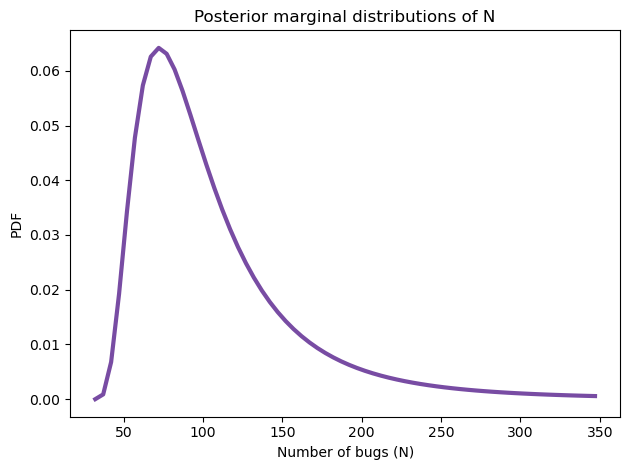

In [118]:
posterior_N.plot(color='C4')

decorate(xlabel='Number of bugs (N)', ylabel='PDF', title='Posterior marginal distributions of N')

In [119]:
posterior_N.mean()

105.76561732196238

<br>

#### `p0`과 `p1`의 주변사후분포와 90% 신용구간

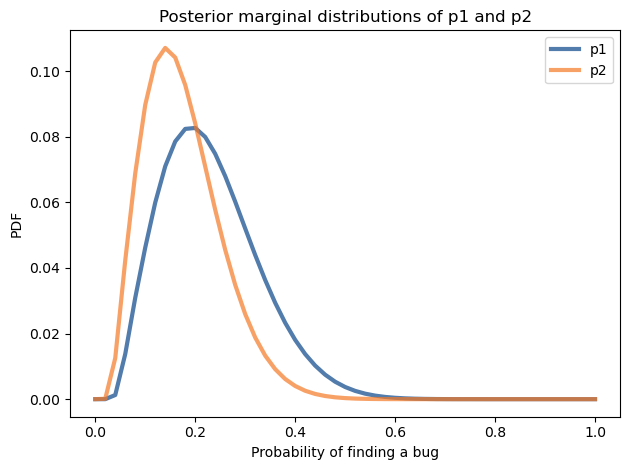

In [120]:
posterior_p1 = posterior_pmf.marginal(1)
posterior_p2 = posterior_pmf.marginal(2)

posterior_p1.plot(label='p1')
posterior_p2.plot(label='p2')

decorate(xlabel='Probability of finding a bug', ylabel='PDF', title='Posterior marginal distributions of p1 and p2')

In [121]:
posterior_p1.mean(), posterior_p1.credible_interval(0.9)

(0.2297065971677734, array([0.1, 0.4]))

In [122]:
posterior_p2.mean(), posterior_p2.credible_interval(0.9)

(0.17501172155925765, array([0.06, 0.32]))

#### 아마도 더 많은 버그를 발견한 검수자는, 버그를 발견할 확률이 더 높음
#### 사후분포평균은 각각 23%와 18%지만, 분포가 겹치는 부분이 많음 (확정적으로 받아들일 수 없음)